In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
df = pd.read_csv("DATA (1).csv")
df.isna().all()
df.head()

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


In [97]:
# Создание метрики успешности
df['SUCCESSFUL'] = df['GRADE'] >= 3

# Удаление ненужных столбцов
df = df.drop(columns=['STUDENT ID', 'COURSE ID', 'GRADE'])

# Посмотрим на первые несколько строк данных
df.head()


,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,SUCCESSFUL
0,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,1,2,1,1,False
1,2,2,3,3,1,2,2,1,1,1,...,1,1,1,3,2,3,2,2,3,False
2,2,2,2,3,2,2,2,2,4,2,...,1,1,1,2,2,1,1,2,2,False
3,1,1,1,3,1,2,1,2,1,2,...,1,1,2,3,2,2,1,3,2,False
4,2,2,1,3,2,2,1,3,1,4,...,1,2,1,2,2,2,1,2,2,False


## Отбор √n признаков

In [98]:
# Количество признаков
n = df.shape[1] - 1  # Исключаем столбец 'SUCCESSFUL'

# Количество признаков для отбора
num_features = int(np.sqrt(n))

# Случайный выбор признаков
selected_features = np.random.choice(df.columns[:-1], num_features, replace=False)

# Отобрать выбранные признаки
df = df[list(selected_features) + ['SUCCESSFUL']]

# Посмотрим на первые несколько строк данных
df.head()

,18,12,8,14,1,SUCCESSFUL
0,2,2,1,1,2,False
1,2,3,1,1,2,False
2,1,2,2,1,2,False
3,1,2,2,1,1,False
4,1,3,3,1,2,False


## 2. Разбиение на выборки

In [ ]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_index = int((1 - test_size) * X.shape[0])
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=['SUCCESSFUL'])
y = df['SUCCESSFUL'].astype(str)  # Преобразование значений в строки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Реализация дерева решений

In [ ]:
# Функции для вычисления энтропии, информационного выигрыша и построения дерева решений
def entropy(data, target_col):
    unique_targets = data[target_col].unique()
    target_counts = data[target_col].value_counts()
    total_rows = data.shape[0]

    result = 0

    for x in unique_targets:
        ct = target_counts[x]
        result += ct / total_rows * np.log2(ct / total_rows)

    return -1 * result

def entropy_info(data, col, target_col):
    unique_col = data[col].unique()
    total_rows = data.shape[0]
    result = 0

    for value in unique_col:
        subset = data[data[col] == value]
        total_count = subset.shape[0]
        target_1_count = subset[subset[target_col] == 'True'].shape[0]
        target_0_count = subset[subset[target_col] == 'False'].shape[0]

        if total_count == 0:
            continue

        if target_1_count == 0:
            target_1_entropy = 0
        else:
            target_1_entropy = -1 * target_1_count / total_count * np.log2(target_1_count / total_count)

        if target_0_count == 0:
            target_0_entropy = 0
        else:
            target_0_entropy = -1 * target_0_count / total_count * np.log2(target_0_count / total_count)

        result += (total_count / total_rows) * (target_1_entropy + target_0_entropy)

    return result

def split_info(data, col):
    unique_col = data[col].unique()
    total_rows = data.shape[0]
    result = 0

    for value in unique_col:
        subset = data[data[col] == value]
        total_count = subset.shape[0]

        if total_count == 0:
            continue

        result += -1 * (total_count / total_rows * np.log2(total_count / total_rows))
    return result

def calculate_for_each(data, target_col):
    columns = data.columns.drop(target_col)
    results = {}
    for x in columns:
        split_info_value = split_info(data, x)
        if split_info_value == 0:
            results[x] = 0
        else:
            results[x] = (entropy(data, target_col) - entropy_info(data, x, target_col)) / split_info_value
    return results

def best_feature_to_split(data, target_col):
    gain_ratios = calculate_for_each(data, target_col)
    if not gain_ratios:
        return None
    best_feature = max(gain_ratios, key=gain_ratios.get)
    return best_feature

def get_ways(data, col, target_col):
    unique_col = data[col].unique()
    result = {}

    for value in unique_col:
        subset = data[data[col] == value]
        total_count = subset.shape[0]
        target_1_count = subset[subset[target_col] == 'True'].shape[0]
        result[value] = target_1_count / total_count if total_count > 0 else 0

    return result

class Node:
    def __init__(self):
        self.prev = None
        self.data = None
        self.result = None
        self.name = None
        self.options = []
        self.links = []

first_node = Node()
first_node.data = X_train.join(y_train) 

floor = [first_node]
next_floor = []
depth = 0

while True:
    depth += 1
    if len(floor) == 0:
        break
    for el in floor:
        data = el.data

        if data is None or data.empty:
            continue

        if 'SUCCESSFUL' not in data.columns:
            continue

        gain_ratio = best_feature_to_split(data, "SUCCESSFUL")

        if gain_ratio is None:
            target_1_count = data[data["SUCCESSFUL"] == 'True'].shape[0]
            total_count = data.shape[0]
            el.result = target_1_count / total_count
            continue

        el.name = gain_ratio
        ways = get_ways(data, gain_ratio, "SUCCESSFUL")

        for way in ways.keys():
            result = ways[way]
            add_node = Node()
            add_node.prev = el

            if result == 0 or result == 1:
                add_node.result = result
            else:
                filtered_df = data[data[str(gain_ratio)] == way]
                filtered_df = filtered_df.drop(columns=[str(gain_ratio)])

                if not filtered_df.empty:
                    add_node.data = filtered_df
                add_node.result = result
                el.options.append(way)
            el.links.append(add_node)
            next_floor.append(add_node)

    floor = next_floor
    next_floor = []

print(depth)

7


In [102]:
def predict(node, sample):
    ct = 0
    while ct <= depth:
        ct += 1
        if node.result == 0 or node.result == 1:
            return node.result

        feature = node.name
        if feature is None:
            return node.result if node.result is not None else 0.5

        value = sample.get(feature)
        checker = False

        for i in range(len(node.options)):
            if value == node.options[i]:
                node = node.links[i]
                checker = True
                break

        if not checker:
            return node.result if node.result is not None else 0.5

    return node.result if node.result is not None else 0.5

def evaluate(tree, test_data):
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for index, row in test_data.iterrows():
        prediction = predict(tree, row)
        actual = row['SUCCESSFUL']

        predicted_class = "True" if prediction >= 0.5 else "False"

        if predicted_class == "True":
            if predicted_class == str(actual):
                TP += 1
            else:
                FP += 1
        else:
            if predicted_class == str(actual):
                TN += 1
            else:
                FN += 1

    return TP, TN, FP, FN

Accuracy: 0.48
Precision: 0.53
Recall: 0.56


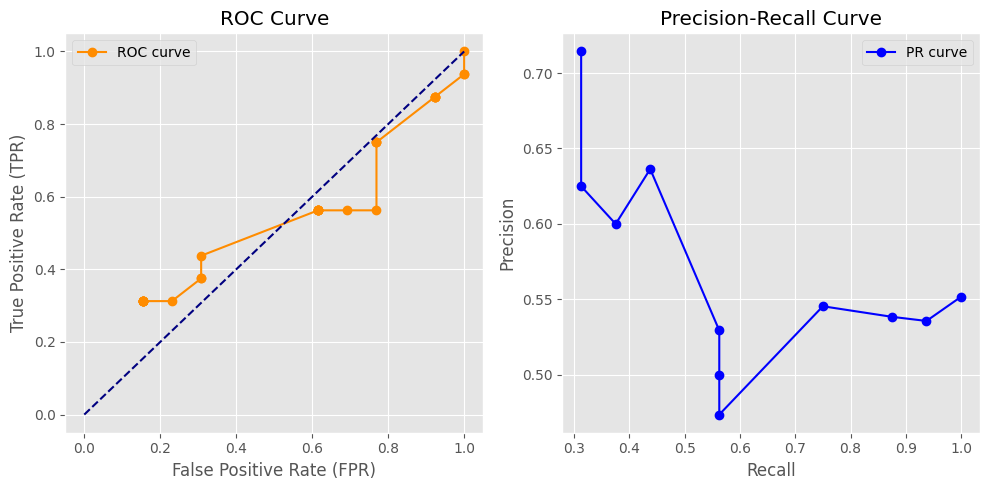

In [103]:
# Объединяем X_test и y_test для оценки
test_data = X_test.join(y_test)

TP, TN, FP, FN = evaluate(first_node, test_data)

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

def roc_curve_manual(y_true, y_scores):
    thresholds = np.sort(y_scores)[::-1]
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds

def pr_curve_manual(y_true, y_scores):
    thresholds = np.sort(np.unique(y_scores))[::-1]
    precision_list = []
    recall_list = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)

        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        if precision > 0 or recall > 0:
            precision_list.append(precision)
            recall_list.append(recall)

    return np.array(recall_list), np.array(precision_list), thresholds

# Преобразование значений в целые числа
y_true = test_data['SUCCESSFUL'].apply(lambda x: 1 if x == 'True' else 0).values
y_scores = np.array([predict(first_node, row) for _, row in test_data.iterrows()])

fpr, tpr, _ = roc_curve_manual(y_true, y_scores)
recall, precision, _ = pr_curve_manual(y_true, y_scores)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', marker='o', label='PR curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()